# Class Activation Map COVID19 CXR Data

In [1]:
# https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923
from __future__ import print_function, division
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import copy
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
from PIL import ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch import topk
import skimage.transform

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.3)),
        transforms.RandomAffine(degrees=0, translate=(0.15,0.1)),
        transforms.RandomAffine(degrees=(-10,10)),
        transforms.Resize(280),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(280),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(os.getenv('HOME'),'covid_data/CXR')
batch_size = 32
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
val_class_names = image_datasets['val'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


preprocess = transforms.Compose([
    transforms.Resize(280),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# model-> model , criterion -> loss function(Cross-Entropy), optimizer -> SGD , sheduler ->LR sheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #현재 시간 받아오기
    since = time.time()
    
    #model.state_dict()는 OrderedDict으로 model의 다양한 정보가 있음
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                #device gpu device설정
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파 계산
                        optimizer.step() # weight 최적화

                # 통계
                running_loss += loss.item() * inputs.size(0) # 평균 Loss에 batch size만큼 곱해준다!
                running_corrects += torch.sum(preds == labels.data) 
                # torch.sum -> 배치 4개를 하나씩 비교해서 더해줌 ex) 3개가 같으면 +3이 됨
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [4]:
# Feature map을 hook을 통해 저장
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [5]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [17]:
model_ft = models.resnet50(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = True
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3321 Acc: 0.8719
val Loss: 0.2244 Acc: 0.9195

Epoch 1/9
----------
train Loss: 0.2381 Acc: 0.9127
val Loss: 0.1887 Acc: 0.9322

Epoch 2/9
----------
train Loss: 0.1922 Acc: 0.9313
val Loss: 0.1861 Acc: 0.9259

Epoch 3/9
----------
train Loss: 0.1578 Acc: 0.9444
val Loss: 0.1535 Acc: 0.9442

Epoch 4/9
----------
train Loss: 0.1566 Acc: 0.9437
val Loss: 0.1607 Acc: 0.9455

Epoch 5/9
----------
train Loss: 0.1430 Acc: 0.9489
val Loss: 0.1517 Acc: 0.9468

Epoch 6/9
----------
train Loss: 0.1439 Acc: 0.9473
val Loss: 0.1542 Acc: 0.9442

Epoch 7/9
----------
train Loss: 0.1396 Acc: 0.9491
val Loss: 0.1537 Acc: 0.9449

Epoch 8/9
----------
train Loss: 0.1407 Acc: 0.9496
val Loss: 0.1605 Acc: 0.9417

Epoch 9/9
----------
train Loss: 0.1380 Acc: 0.9486
val Loss: 0.1509 Acc: 0.9436

Training complete in 21m 34s
Best val Acc: 0.946768


In [21]:
torch.save(model_ft.state_dict(), 'cam_model')

In [28]:
torch.save(model_ft, 'cam_model_entire')

In [6]:
model = torch.load('cam_model_entire')

In [7]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [112]:
image_dir = os.path.join(os.getenv('HOME'),'covid_data/CXR')
image_dir = os.path.join(image_dir,'val/covid-19/COVID-19(116).png')
image_dir

'/home/aiffel0042/covid_data/CXR/val/covid-19/COVID-19(116).png'

In [113]:
from matplotlib.pyplot import imshow

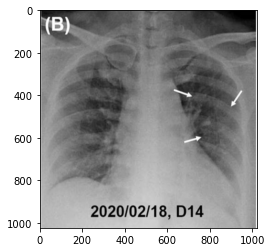

In [114]:
a = cv2.imread(image_dir)
org_img = Image.fromarray(a)
imshow(org_img)

In [115]:
aug_img = preprocess(org_img)
type(aug_img)

torch.Tensor

In [116]:
class_names = image_datasets['train'].classes

In [117]:
prediction_var = Variable((aug_img.unsqueeze(0)).cuda(), requires_grad=True)

In [118]:
prediction_var = prediction_var.to(device)

In [119]:
model = model.to(device)

In [120]:
final_layer = model._modules.get('layer4')
final_layer

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [121]:
activated_features = SaveFeatures(final_layer)
activated_features

In [122]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

<ipython-input-122-5893ac2c4294>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [123]:
topk(pred_probabilities,1)
weight_softmax_params = list(model_ft._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

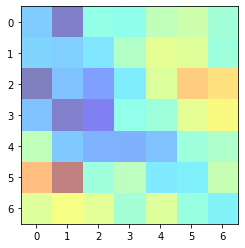

In [124]:
imshow(overlay[0], alpha=0.5, cmap='jet')

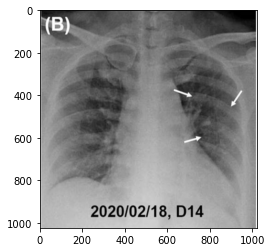

In [125]:
imshow(org_img)

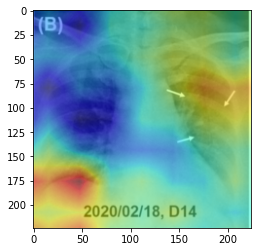

In [126]:
imshow(display_transform(org_img))
imshow(skimage.transform.resize(overlay[0], aug_img.shape[1:3]), alpha=0.5, cmap='jet')

## Module

In [77]:
model = torch.load('cam_model_entire')
model.eval()
final_layer = model._modules.get('layer4')

activated_features = SaveFeatures(final_layer)

In [78]:
image_dir = os.path.join(os.getenv('HOME'),'covid_data/CXR')
image_dir = os.path.join(image_dir,'val/covid-19/COVID-00025.jpg')

a = cv2.imread(image_dir)
org_img = Image.fromarray(a)
aug_img = preprocess(org_img)

prediction_var = Variable((aug_img.unsqueeze(0)).cuda(), requires_grad=True)

prediction_var = prediction_var.to(device)

model = model.to(device)

In [79]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

topk(pred_probabilities,1)
weight_softmax_params = list(model_ft._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

<ipython-input-79-3f99e9efa268>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


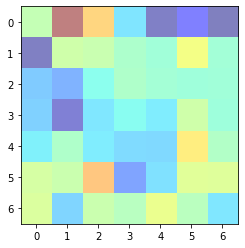

In [92]:
imshow(overlay[0], alpha=0.5, cmap='jet')

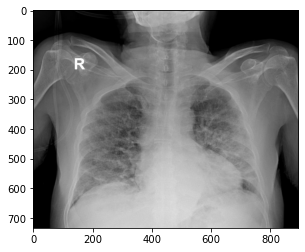

In [94]:
imshow(org_img)

In [109]:
aug_img.shape[1:3]

torch.Size([224, 224])

In [110]:
display_transform = transforms.Compose([
   transforms.Resize((224,224))])

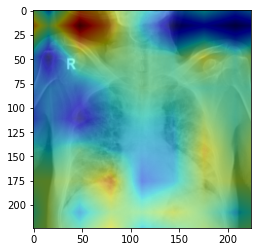

In [111]:
imshow(display_transform(org_img))
imshow(skimage.transform.resize(overlay[0], aug_img.shape[1:3]), alpha=0.5, cmap='jet')